In [19]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits
from astropy.table import Table
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, Galactocentric, ICRS
from astropy.constants import kpc, au
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
from numba import njit

from implied_d_vr import implied_calculations
from selections import is_HVS

import healpy as hp

# Testing my implementation of Sills selections

If I apply the selections to the 600 HVS candidates, all of them should pass

In [32]:
# Test with Sill's already computed stars
# Load the data
sills_candidates = pd.read_csv("/Users/mncavieres/Documents/2024-2/HVS/Data/Sill Candidates/full_candidate_list.txt")

# Query Gaia DR3 for the parallax and proper motions
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy import units as u

source_ids_sills_candidates = sills_candidates["GaiaDR3_source_id"].values
source_ids_str = ','.join(str(id) for id in source_ids_sills_candidates)


# Connect to Gaia
job = Gaia.launch_job_async(f"SELECT * \
                             FROM gaiaedr3.gaia_source \
                            JOIN external.gaiaedr3_distance USING (source_id) \
                             WHERE source_id IN ({source_ids_str}) \
                            ")

# Get the results
gaia_results = job.get_results()
#gaia_results = gaia_results.to_pandas()


INFO: Query finished. [astroquery.utils.tap.core]


In [33]:
data = implied_calculations(gaia_results)

Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!


In [34]:
data

solution_id,designation,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,flag,source_id,implied_parallax,implied_parallax_error,VGCR,VR
,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg,pc,pc,pc,pc,pc,pc,,,1 / pc,1 / pc,,
int64,object,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,object,int64,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 3367563599569024,627526622,2016.0,49.07700564449039,0.35985,5.748888069129046,0.37053367,0.32218677049802524,0.45902526,0.7018933,3.6308248,3.628164015440435,0.48468414,-0.13897729227328248,0.42572019,0.218995,0.0074679204,0.062246747,-0.12862405,-0.48204195,-0.12952839,-0.116383426,-0.014902249,0.17474893,0.19979985,191,0,187,4,3.8294702,275.31723,1.5297276,3.1463661,95,False,--,1.4119714,0.111067384,-0.2147179,-0.010446816,-0.07597882,0.1365481,-0.059920307,22,14,0.7050496,22,8,0,0.037126087,102.58662,0,0,1.2059196,0.32398942,0.22979695,0.519942,0.8287964,-103.31896,-26.994312,-44.83262,29.547693,False,181,277.2104094293237,1.0885421,254.6621,19.580343,7,156.6090536287528,14.824695,10.564066,19.8515,9,160.3623975520148,21.23003,7.5535645,19.23514,0,0,0,0,0,1.1434327,0.6163597,0.2711563,0.3452034,--,--,0,--,--,--,175.18245387039892,-41.96

In [11]:
#data.to_pandas().to_csv("/Users/mncavieres/Documents/2024-2/HVS/Data/Sill Candidates/sills_candidates.csv", index=False)

In [13]:
from astropy.table import Table, vstack

# What is going on with HEALPix pixels

All of the candidates should be within the NSIDE = 3, RING scheme  HEALPix pixels given by the following list

In [35]:
# Expand the specified pixel ranges into a list
pixels = np.concatenate([
    np.arange(0, 20),          # 0–19
    np.arange(22, 32),         # 22–31
    np.arange(35, 43),         # 35–42
    np.arange(46, 56),         # 46–55
    np.arange(58, 63),         # 58–62
    [65, 66],
    np.arange(69, 74),         # 69–73
    [78],
    np.arange(82, 86),         # 82–85
    np.arange(93, 97),         # 93–96
    [101, 102, 103],
    [107]
    ])

In [61]:
# compute the NSIDE 3 ring scheme HEALPix pixel for each source
nside = 3
# Compute the HEALPix pixel number for each coordinate (ring ordering)
pix_nums = hp.ang2pix(nside, data['l'], data['b'], nest=False, lonlat=True)

# Compute with RA and DEC
theta = np.radians(90 - data['dec'])  # Colatitude in radians
phi = np.radians(-data['ra'])  # Longitude in radians

# Compute the HEALPix pixel number for each coordinate (ring ordering)
pix_nums = hp.ang2pix(nside, theta, phi, nest=False)
#pix_nums = hp.ang2pix(nside,np.pi*(90-dec_deg)/180,np.pi*ra_deg/180)

In [62]:
bool_check_pix = np.isin(pix_nums, pixels)

In [63]:
for boolean in bool_check_pix:
    if not boolean:
        print("There are stars outside the pixel range")


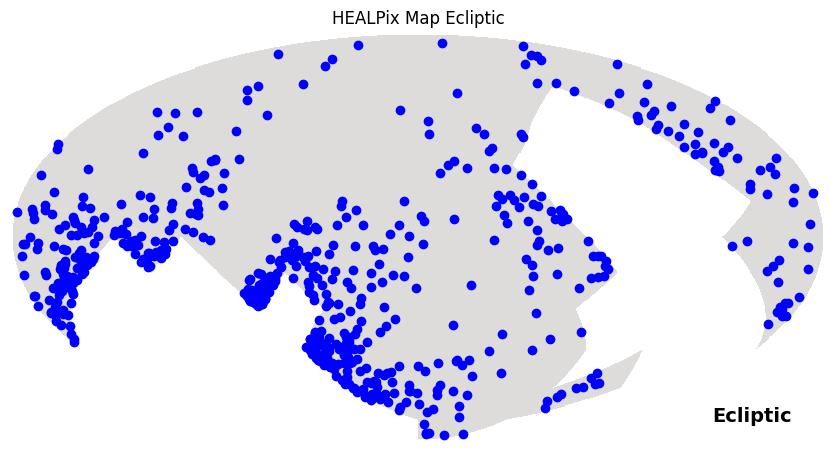

In [64]:
# Call the function to plot
#plot_healpix_with_marked_pixels(pixels, nside=3)
# also plot failed stars
# Create a blank map with zeros
nside = 3
npix = hp.nside2npix(nside)
healpix_map = np.full(npix, hp.UNSEEN)  # Fill with UNSEEN values

# Mark the specified pixels with a value (e.g., 1)
healpix_map[pixels] = 1



# Plot the map using mollweide projection and show the graticule
#hp.mollview(healpix_map, title="HEALPix Graticule with Marked Pixels", cmap='coolwarm', badcolor='white',
#            norm=None, cbar=False, coord='E', nest = False)
# Plot the HEALPix map using mollweide projection centered on the Galactic plane
hp.mollview(healpix_map, title="HEALPix Map Ecliptic", cmap='coolwarm', badcolor='white',
            norm=None, cbar=False, coord='E', rot=(0, 0), nest=False)

theta = np.radians(90 - data['dec'])  # Colatitude in radians
phi = np.radians(-data['ra'])  # Longitude in radians
hp.projscatter(theta, phi, marker='o', color='blue', lonlat=False)    
#hp.projscatter(data['l'], data['b'], marker='o', color='blue', lonlat = True)
# Display the plot
plt.show()



In [44]:
min(data['l']), max(data['l']), min(data['b']), max(data['b'])

(np.float64(0.13001169766083248),
 np.float64(359.96147699313155),
 np.float64(-83.63003032364453),
 np.float64(80.96007358012568))